# Ячейка 1: Импорт библиотек и загрузка данных

In [56]:
# Ячейка 1: Импорт и загрузка данных (формат вывода как на скрине)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter
import random

# чтобы графики сразу показывались в ноутбуке
%matplotlib inline

# Указываем имя файла для загрузки
file_path = 'cat_dog_noisy_300.csv'

# Загружаем данные из CSV-файла в DataFrame
try:
    df = pd.read_csv(file_path)
    print(f"Файл '{file_path}' успешно загружен.")
except FileNotFoundError:
    print(f"Ошибка: Файл '{file_path}' не найден. Убедитесь, что он находится в той же папке, что и ваш Notebook.")
    # В случае ошибки, создаем пустой DataFrame, чтобы избежать дальнейших сбоев
    df = pd.DataFrame()

if not df.empty:
    # Посмотрим на первые 5 строк, чтобы убедиться, что все загрузилось правильно
    print("\nПервые 5 строк данных:")
    # Печатаем head как текст, чтобы формат был как в вашем примере
    print(df.head().to_string())

    print("\nИнформация о данных:")
    df.info()


Файл 'cat_dog_noisy_300.csv' успешно загружен.

Первые 5 строк данных:
   active_sport  hours_outside  likes_active_leisure  likes_passive_leisure  travels_often  is_extrovert  is_introvert  lives_in_house  lives_in_apartment  park_nearby  has_children  wants_to_love  wants_to_be_loved  monthly_pet_spending  comfortable_noise_level_db  weekly_cleaning_sessions pet_preference
0             1              7                     1                      0              0             1             0               1                   0            1             1              1                  1                  6975                          72                         2            dog
1             1              8                     1                      1              0             1             0               1                   0            1             1              1                  1                  7272                          70                         3            dog
2       

# Ячейка 2: Подготовка данных для модели

In [57]:
assert 'df' in globals() and not df.empty, "Датасет пуст. Сначала выполните ячейку с загрузкой CSV."

# если не задано ранее, подставим дефолты
if 'target_col' not in globals():
    target_col = 'pet_preference'   # поменяйте при необходимости
if 'random_state' not in globals():
    random_state = 42

# 1) отделим признаки и целевую
X_df = df.drop(columns=[target_col])
y_raw = df[target_col]

# 2) текстовые метки -> числа (cat -> 0, dog -> 1), при необходимости поменяйте mapping
label_map = {'cat': 0, 'dog': 1}
# если в данных другие названия — создадим mapping автоматически
if not set(y_raw.unique()).issubset(label_map.keys()):
    unique = sorted(y_raw.unique())
    label_map = {cls: i for i, cls in enumerate(unique)}

y = y_raw.map(label_map).to_numpy()
X = X_df.to_numpy(dtype=float)

# --- ручной stratified train/test split ---
def train_test_split_stratified(X, y, test_size=0.2, random_state=42):
    rng = random.Random(random_state)
    idx_per_class = {}
    for i, label in enumerate(y):
        idx_per_class.setdefault(label, []).append(i)
    for cls in idx_per_class:
        rng.shuffle(idx_per_class[cls])

    test_idx, train_idx = [], []
    for cls, idxs in idx_per_class.items():
        n_test = max(1, int(len(idxs) * test_size))
        test_idx.extend(idxs[:n_test])
        train_idx.extend(idxs[n_test:])
    rng.shuffle(train_idx)
    rng.shuffle(test_idx)

    X_train = X[train_idx]
    X_test  = X[test_idx]
    y_train = y[train_idx]
    y_test  = y[test_idx]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_stratified(
    X, y, test_size=0.2, random_state=random_state
)

# --- ручная z-нормализация (fit на train, transform на train/test) ---
def zscore_fit(X_train):
    means = X_train.mean(axis=0)
    stds = X_train.std(axis=0, ddof=0)
    stds[stds == 0] = 1.0  # защита от деления на ноль
    return means, stds

def zscore_transform(X, means, stds):
    return (X - means) / stds

means, stds = zscore_fit(X_train)
X_train_scaled = zscore_transform(X_train, means, stds)
X_test_scaled  = zscore_transform(X_test,  means, stds)

print(f"Размер обучающей выборки: {X_train_scaled.shape}")
print(f"Размер тестовой выборки:  {X_test_scaled.shape}")


Размер обучающей выборки: (349, 16)
Размер тестовой выборки:  (86, 16)


# Ячейка 3: Оценка базовой модели (k=5)

Эта ячейка полезна, чтобы видеть результат для одного конкретного k перед тем, как мы начнем поиск лучшего.

Точность (Accuracy) при k=5: 0.9070


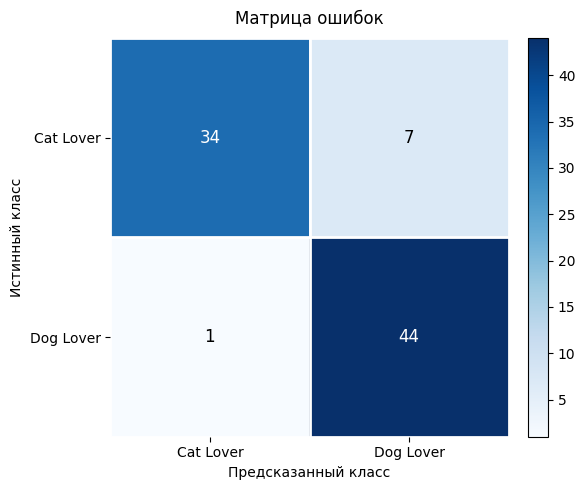

In [58]:
def euclidean(a: np.ndarray, b: np.ndarray) -> float:
    """
    Евклидово расстояние:
        d(x, y) = sqrt( sum_{i=1}^n (x_i - y_i)^2 )
    Реализация по определению.
    """
    s = 0.0
    for i in range(len(a)):
        d = a[i] - b[i]
        s += d * d
    return math.sqrt(s)

def knn_predict(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, k: int = 5) -> np.ndarray:
    """Простая реализация k-NN с мажоритарным голосованием и детерминированной ничьей."""
    preds = []
    for x in X_test:
        dists = [(euclidean(x, X_train[i]), y_train[i]) for i in range(len(X_train))]
        dists.sort(key=lambda t: t[0])
        topk = [lab for _, lab in dists[:k]]
        counts = Counter(topk)
        best_count = max(counts.values())
        best_labels = sorted([lab for lab, c in counts.items() if c == best_count])
        preds.append(best_labels[0])
    return np.array(preds)

def accuracy_score_manual(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(y_true == y_pred))

def confusion_matrix_manual(y_true: np.ndarray, y_pred: np.ndarray, labels=None):
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))
    index = {lab: i for i, lab in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[index[t], index[p]] += 1
    return labels, cm

# --- предсказания на тесте ---
k_base = 5
y_pred = knn_predict(X_train_scaled, y_train, X_test_scaled, k=k_base)

# --- метрики ---
acc = accuracy_score_manual(y_test, y_pred)
labels, cm = confusion_matrix_manual(y_test, y_pred, labels=sorted(np.unique(y)))
print(f"Точность (Accuracy) при k={k_base}: {acc:.4f}")

# --- подготовим красивые подписи классов, если есть исходное отображение ---
inv_map = None
if 'label_map' in globals():
    inv_map = {v: k for k, v in label_map.items()}
pretty = {'cat': 'Cat Lover', 'dog': 'Dog Lover'}
tick_names = []
for l in labels:
    if inv_map and l in inv_map:
        tick_names.append(pretty.get(inv_map[l], str(inv_map[l]).title()))
    else:
        tick_names.append(str(l))

# --- матрица ошибок (без seaborn), с цветами и аннотациями ---
fig, ax = plt.subplots(figsize=(6, 5), facecolor='white')
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

ax.set_title("Матрица ошибок", pad=10)
ax.set_xlabel("Предсказанный класс")
ax.set_ylabel("Истинный класс")
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(tick_names)
ax.set_yticklabels(tick_names)

# подписи в ячейках с авто-контрастом
threshold = cm.max() / 2.0 if cm.size else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        txt_color = "white" if cm[i, j] > threshold else "black"
        ax.text(j, i, cm[i, j], ha="center", va="center", color=txt_color, fontsize=12)

# аккуратная рамка/сетка и цветовая шкала
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(cm.shape[1]+1)-0.5, minor=True)
ax.set_yticks(np.arange(cm.shape[0]+1)-0.5, minor=True)
ax.grid(which="minor", color="white", linestyle='-', linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



# Ячейка 4: Поиск оптимального значения k
Это новая, самая важная ячейка. Она автоматизирует поиск лучшего k.

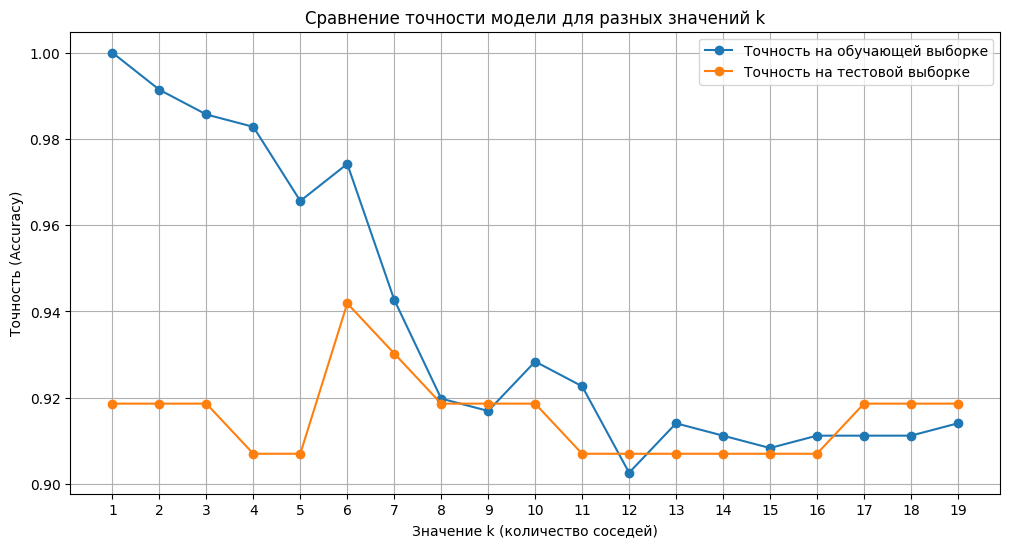

[0.9186046511627907, 0.9186046511627907, 0.9186046511627907, 0.9069767441860465, 0.9069767441860465, 0.9418604651162791, 0.9302325581395349, 0.9186046511627907, 0.9186046511627907, 0.9186046511627907, 0.9069767441860465, 0.9069767441860465, 0.9069767441860465, 0.9069767441860465, 0.9069767441860465, 0.9069767441860465, 0.9186046511627907, 0.9186046511627907, 0.9186046511627907]

Анализ завершен.
Наилучшее значение k найдено: 6
Максимальная точность на тестовой выборке: 0.94


In [59]:
# Ячейка 4: Поиск оптимального значения k
# Будем использовать только нечетные значения, чтобы избежать ничьей при голосовании
k_range = range(1, 20, 1)  # 1..19 с шагом 1

# Создаем списки для хранения точности на обучающей и тестовой выборках
train_scores = []
test_scores  = []

# Проходим в цикле по всем значениям k
for k in k_range:
    # "Создаем и обучаем модель" — вместо sklearn считаем предсказания вручную

    # Считаем точность на обучающей выборке и добавляем в список
    y_pred_train = knn_predict(X_train_scaled, y_train, X_train_scaled, k=k)
    train_scores.append(accuracy_score_manual(y_train, y_pred_train))

    # Считаем точность на тестовой выборке и добавляем в список
    y_pred_test = knn_predict(X_train_scaled, y_train, X_test_scaled, k=k)
    test_scores.append(accuracy_score_manual(y_test, y_pred_test))

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(list(k_range), train_scores, marker='o', label='Точность на обучающей выборке')
plt.plot(list(k_range), test_scores,  marker='o', label='Точность на тестовой выборке')
plt.xlabel('Значение k (количество соседей)')
plt.ylabel('Точность (Accuracy)')
plt.title('Сравнение точности модели для разных значений k')
plt.xticks(list(k_range))
plt.grid(True)
plt.legend()
plt.show()

# Находим и выводим лучшее значение k
k_list = list(k_range)
best_k_index = int(np.argmax(test_scores))
best_k = k_list[best_k_index]
best_accuracy = max(test_scores)

print(test_scores)
print("\nАнализ завершен.")
print(f"Наилучшее значение k найдено: {best_k}")
print(f"Максимальная точность на тестовой выборке: {best_accuracy:.2f}")




# Ячейка 5: Визуализация с наилучшим значением k
Теперь мы используем best_k, найденное в предыдущей ячейке, для финальной визуализации.

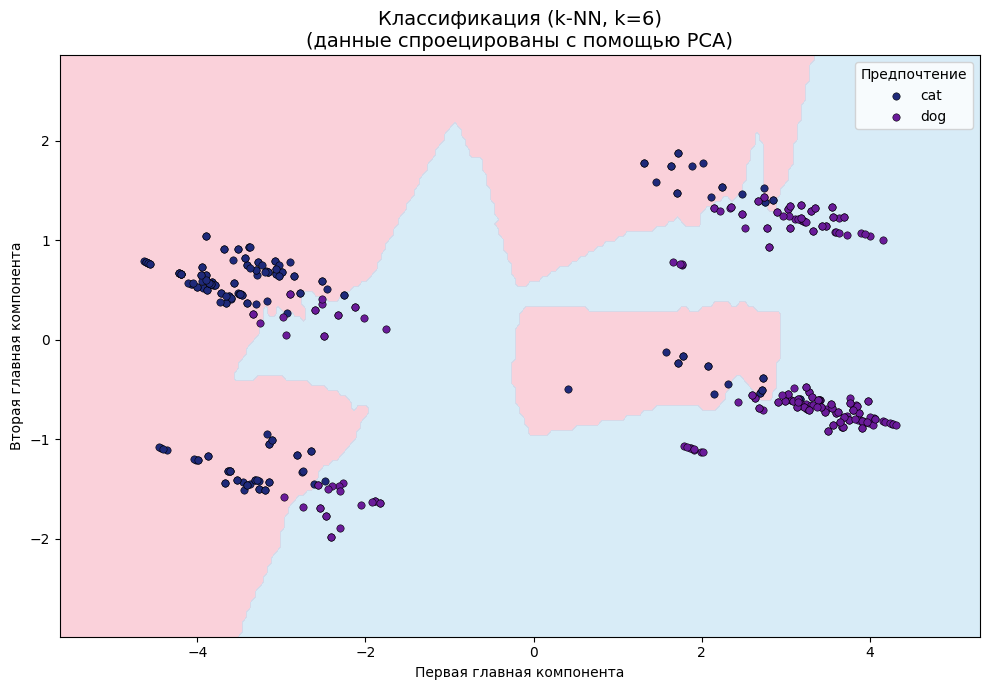

In [60]:
# --- PCA вручную (если не определены ранее) ---
def pca_fit(X: np.ndarray, n_components: int = 2):
    mean = X.mean(axis=0, keepdims=True)
    Xc = X - mean
    cov = np.cov(Xc, rowvar=False)
    vals, vecs = np.linalg.eigh(cov)              # симметричная ковариационная
    order = np.argsort(vals)[::-1]
    W = vecs[:, order[:n_components]]
    return mean, W

def pca_transform(X: np.ndarray, mean: np.ndarray, W: np.ndarray):
    return (X - mean) @ W

# 1) Обучаем PCA на ВЕСЬ набор (как в твоём примере с sklearn.PCA().fit_transform(scaler.transform(X)))
X_all_scaled = np.vstack([X_train_scaled, X_test_scaled])
pca_mean, pca_W = pca_fit(X_all_scaled, n_components=2)
X_all_2d = pca_transform(X_all_scaled, pca_mean, pca_W)

# y для всех точек в том же порядке:
y_all = np.concatenate([y_train, y_test])

# 2) Обучим k-NN на 2D-координатах всех точек (как у тебя с KNeighborsClassifier().fit(X_pca, y))
k_plot = best_k if 'best_k' in globals() else 1

# 3) Сетка для фона (решающих областей)
x_min, x_max = X_all_2d[:, 0].min() - 1.0, X_all_2d[:, 0].max() + 1.0
y_min, y_max = X_all_2d[:, 1].min() - 1.0, X_all_2d[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))
grid = np.c_[xx.ravel(), yy.ravel()]

# предсказания классов на сетке
Z = knn_predict(X_all_2d, y_all, grid, k=k_plot).reshape(xx.shape)

# 4) Палитры — фон и точки (как на скрине)
bg_colors = ['#f7b3c2', '#bfe0f3']  # розовый / светло-голубой
point_colors = {0: '#1f2a7a', 1: '#6a1b9a'}  # тёмно-синий / фиолетовый

# подписи классов
inv_map = {v: k for k, v in label_map.items()} if 'label_map' in globals() else None
def class_name(lbl: int):
    if inv_map:
        return inv_map.get(lbl, str(lbl))
    return str(lbl)

# 5) Рисуем
plt.figure(figsize=(10, 7))

# фон: две дискретные области
plt.contourf(xx, yy, Z, levels=[-0.5, 0.5, 1.5], colors=bg_colors, alpha=0.6)

# точки — один маркер, разные цвета для классов (как на твоём скрине)
for cls in np.unique(y_all):
    pts = X_all_2d[y_all == cls]
    plt.scatter(pts[:, 0], pts[:, 1],
                s=28, marker='o', edgecolor='k', linewidth=0.4,
                c=point_colors.get(cls, 'gray'),
                label=class_name(cls))

plt.title(f"Классификация (k-NN, k={k_plot})\n(данные спроецированы с помощью PCA)", fontsize=14)
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.legend(title="Предпочтение", loc='upper right')
plt.tight_layout()
plt.show()
